# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is the csv

## 02 - Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [11]:
df = pd.read_csv('data/monthly_champagne_sales.csv')
df.head()

,"Month,""Sales"""
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


👉 Convert dataframe with datetime objects as index to make it look like this
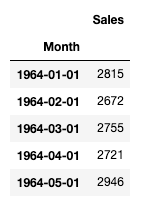

In [12]:
df['Month'] = df.index
df.columns = df.columns.str.replace('Month,"Sales"', 'Sales')
df['Month'] = df['Month'] + '-01'

# Setting the 'Month' column as the index and converting it to a DatetimeIndex object
df = df.set_index(pd.to_datetime(df['Month'], format='%Y-%m-%d'))

# Removing the 'Month' column from the DataFrame
df = df.drop(columns=['Month'])
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

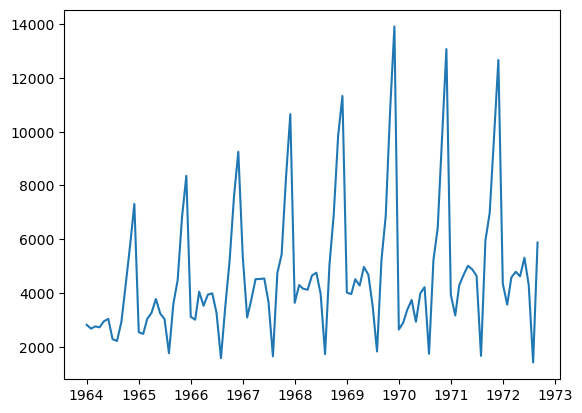

In [15]:
plt.plot(df)

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

<function matplotlib.pyplot.show(close=None, block=None)>

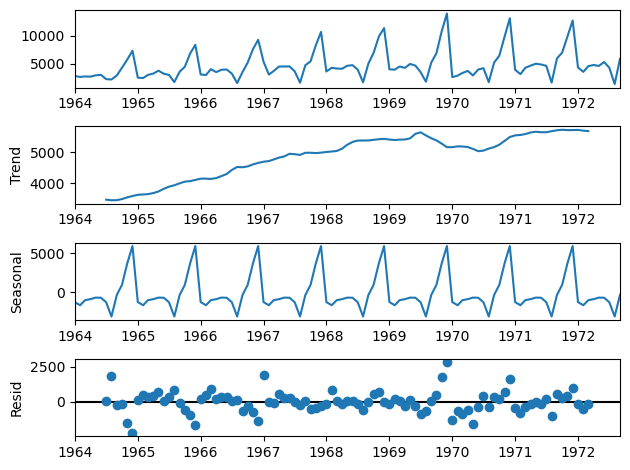

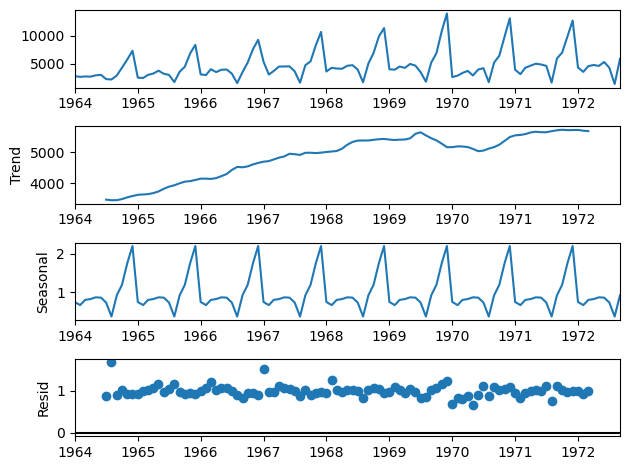

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

add = seasonal_decompose(df,model="additive")
mul = seasonal_decompose(df,model= "multiplicative")
add.plot()
mul.plot()
plt.show

👉 De-seasonalize this time serie using the decomposition of your choice

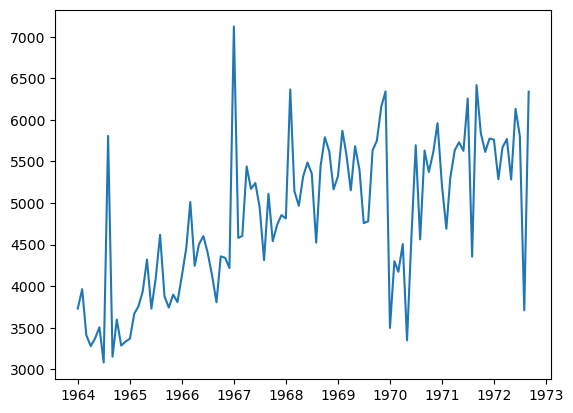

In [33]:
Deseasonalite= df["Sales"] / mul.seasonal
plt.plot(Deseasonalite)

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [34]:
df_train = df[:'1969-12-31']
df_test = df['1970-01-01':]

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [36]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['Sales'], autolag='AIC')


(-1.8335930563276195,
 0.3639157716602467,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

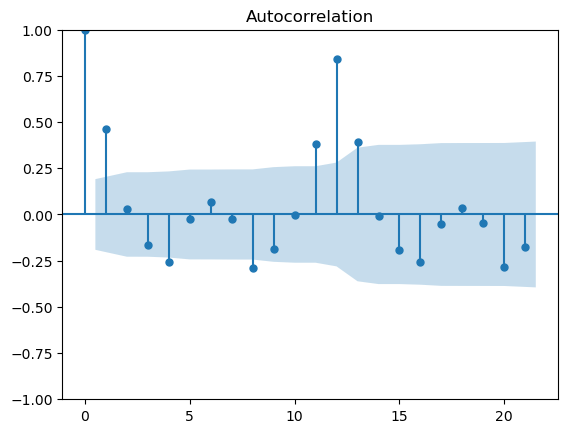

In [42]:
plot_acf(df.Sales);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

<AxesSubplot:xlabel='Month'>

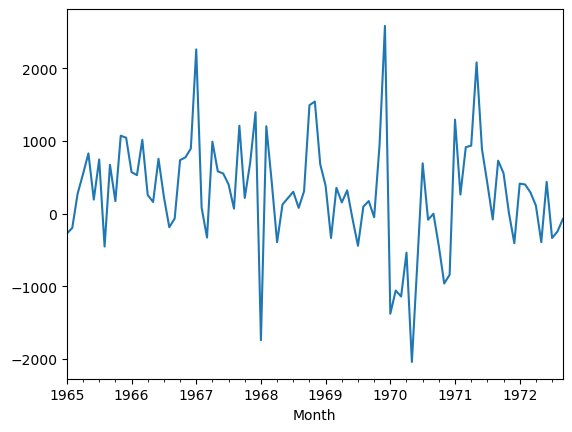

In [43]:
diff12 = df.Sales.diff(12).dropna()

diff12.plot()

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

In [44]:
diff12.diff(1).dropna()

adfuller(diff12.diff(1).dropna(), autolag='AIC')

(-4.427713497307515,
 0.0002650462849293356,
 11,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 1290.6965709705498)

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


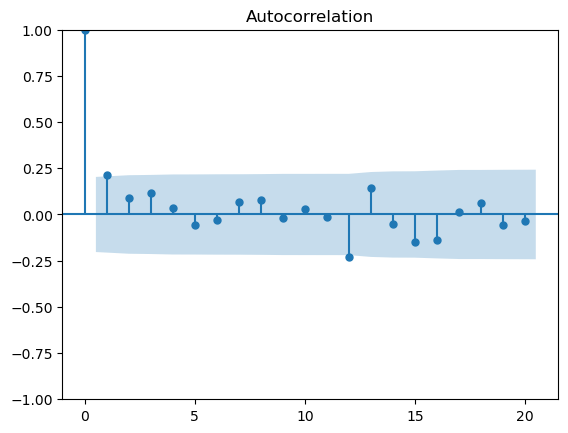

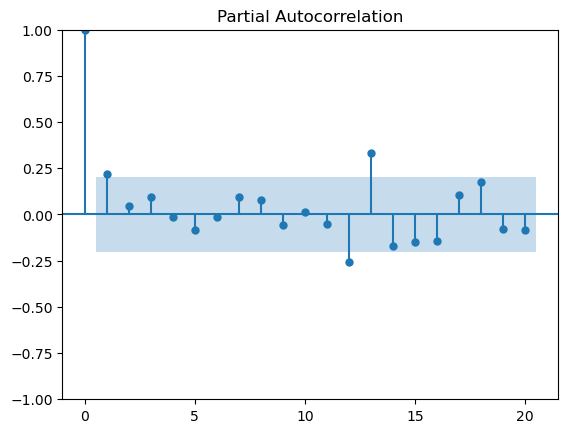

In [45]:
plot_acf(diff12)

plot_pacf(diff12)

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [61]:
import pmdarima as pm
auto_model = pm.auto_arima(df_train['Sales'], start_p=0, start_q=0,
                             max_p=2, max_q=2,
                             start_P=0,
                             D=1,
                             start_Q=0,
                             max_P=1,
                             max_D=1,
                             max_Q=1,
                             d=0,
                             m=12,
                             seasonal=True, 
                             njobs=-1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.07 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.14 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.30 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.870 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood 

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [55]:
forecast, conf_int = auto_model.predict(n_periods=len(df_test), return_conf_int=True)

# Save the central, upper, and lower predictions as Pandas Series

central = pd.Series(forecast,index=df_test.index)
lower = pd.Series(conf_int[:,0],index=df_test.index)
upper = pd.Series(conf_int[:,1],index=df_test.index)

👇 Run the cell below to plot your predictions against reality

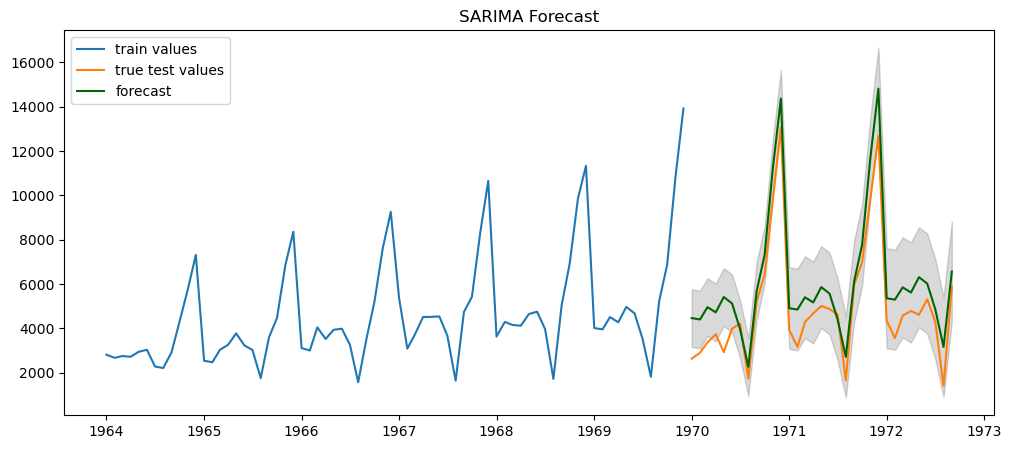

In [56]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


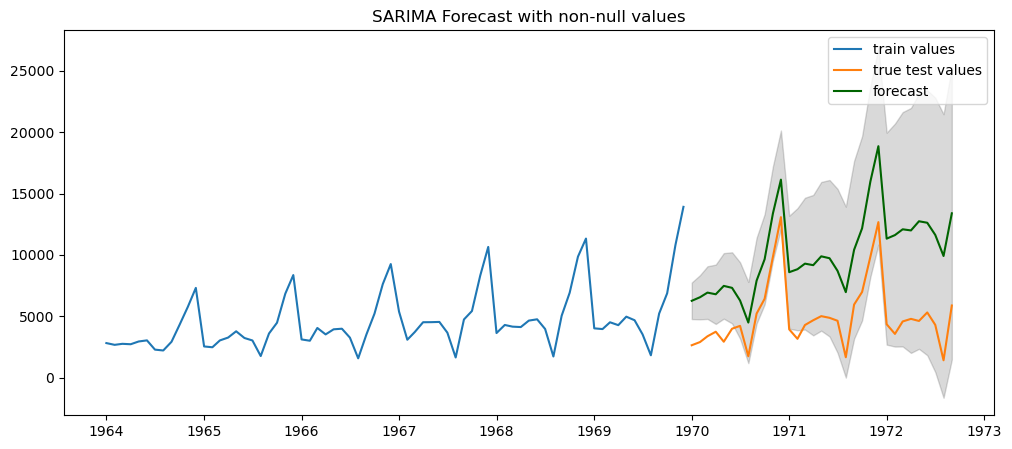

In [59]:
model_2 = pm.arima.ARIMA((1,1,0),(1,1,0,12))
model_2.fit(df_train['Sales'])


forecast, conf_int = model_2.predict(n_periods=len(df_test), return_conf_int=True)

# Save the central, upper, and lower predictions as Pandas Series

central = pd.Series(forecast,index=df_test.index)
lower = pd.Series(conf_int[:,0],index=df_test.index)
upper = pd.Series(conf_int[:,1],index=df_test.index)



plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                lower, 
                upper, 
                color='k', alpha=.15)

plt.title("SARIMA Forecast with non-null values")
plt.legend()
plt.show()

# Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [67]:
# Add lagged values
import pandas as pd
df_shift = pd.DataFrame(range(15))
for i in range(12):
    df_shift[i] = df_shift[0].shift(i)
df_shift.columns = df_shift.columns+1

# Drop nan

# create df_train and df_test 
df_train = df[:'1969-12-31']
df_test = df['1970-01-01':]
df_shift

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,6,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
7,7,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN
8,8,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN
9,9,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN


In [68]:
# Keep track of test_indexes
test_indexes = df_test.index
test_indexes

DatetimeIndex(['1970-01-01', '1970-02-01', '1970-03-01', '1970-04-01',
               '1970-05-01', '1970-06-01', '1970-07-01', '1970-08-01',
               '1970-09-01', '1970-10-01', '1970-11-01', '1970-12-01',
               '1971-01-01', '1971-02-01', '1971-03-01', '1971-04-01',
               '1971-05-01', '1971-06-01', '1971-07-01', '1971-08-01',
               '1971-09-01', '1971-10-01', '1971-11-01', '1971-12-01',
               '1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [72]:
# Create X, y
x_train = df_train.drop('Sales', axis=1)
y_train = df_train['Sales']

x_test = df_test.drop('Sales', axis=1)
y_test =df_test['Sales']


👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA